In [1]:
N = 8
J_value = 1
J_matrix_alpha = 1

In [2]:
import os
import numpy as np
from scipy.sparse.linalg import eigs
from scipy.sparse.linalg import eigsh
from scipy.interpolate import Akima1DInterpolator
from scipy.linalg import expm
import time
from scipy import sparse
import matplotlib.pyplot as plt
import pandas
import scipy
import torch
import torch.optim as optim
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# device = torch.device( "cpu")
np.set_printoptions(precision=6)
# initialize variables
# Q is the dimension
Q = pow(2, N)

# decimal number to binary array function
def D2B(num):
    string = f'{num:1b}'
    result = np.zeros(N - len(string), int)

    for ele in string:
        result = np.append(result, int(ele))

    return result

# decimal number to binary array function
def D2B_with_digit(num,digit):
    string = f'{num:1b}'
    result = np.zeros(digit - len(string), int)

    for ele in string:
        result = np.append(result, int(ele))

    return result

# binary array to decimal function
def B2D(array):
    res = 0
    for ele in array:
        res = (res << 1) | ele
    return res

def spin_reflection(array):
    new_array = np.zeros(len(array),dtype=int)
    for i in range(len(array)):
        if array[i] == 1:
            new_array[i] = 0
        else:
            new_array[i] = 1
    return new_array

def spatial_reflection(array):
    new_array = array[::-1]
    return new_array

# start my main function

# initialize J matrix
J_matrix = np.zeros((N, N), dtype='float64')

for i in range(N):
    for j in range(N):
        if j >= (i + 1):
            J_matrix[i][j] = J_value/pow(abs(i-j),J_matrix_alpha)

In [3]:
# start to get what product states are having the same symmtries
loop_state_list = np.linspace(0,Q-1,num=Q,dtype=int)

couple_state_matrix = []
sign_matrix = []
# this is the final result for the states to consctruct basis

for n in range(Q):  # n is an unused index

    # couple_num_list would be my result for each state we loop

    if len(loop_state_list)!=0: # loop for couple number for one state

        couple_num_list = [] # this is the list to store all the number that couple to the number we are looping
        couple_num_list = np.array(couple_num_list, dtype=int)
        state_num = loop_state_list[0]
        couple_num_list = np.append(couple_num_list,state_num)

        for m in range(Q): # loop for spin and spatial for all states inside the couple number list

            if m==0:

                couple_num_list_old =couple_num_list

                for i in range(len(couple_num_list)):
                    number = couple_num_list[i]
                    array = D2B(number)

                    # spin reflection
                    spin_relfection_array = spin_reflection(array)
                    spin_number = B2D(spin_relfection_array)
                    couple_num_list =np.append(couple_num_list,spin_number)



                    # # spatial reflection
                    spatial_relfection_array = spatial_reflection(array)
                    spatial_number = B2D(spatial_relfection_array)
                    couple_num_list =np.append(couple_num_list,spatial_number)

                    # remove the repeated element
                    couple_num_list = np.unique(couple_num_list)
            else:

                if len(couple_num_list_old) != len(couple_num_list):
                    # update couple_num_list_old first
                    couple_num_list_old =couple_num_list

                    for i in range(len(couple_num_list)):
                        number = couple_num_list[i]
                        array = D2B(number)

                        # spin reflection
                        spin_relfection_array = spin_reflection(array)
                        spin_number = B2D(spin_relfection_array)
                        couple_num_list =np.append(couple_num_list,spin_number)


                        # # spatial reflection
                        spatial_relfection_array = spatial_reflection(array)
                        spatial_number = B2D(spatial_relfection_array)
                        couple_num_list = np.append(couple_num_list,spatial_number)

                        # remove the repeated element
                        couple_num_list = np.unique(couple_num_list)

        # now we have final couple_num_list
        couple_state_matrix.append(couple_num_list.tolist())

        # remove the ones already found
        for j in range(len(couple_num_list)):
            loop_state_list = np.delete(loop_state_list, np.where(loop_state_list ==couple_num_list[j] ))

In [4]:
# initialize H matrix
couple_dimen = len(couple_state_matrix)

HA_matrix = np.zeros((couple_dimen, couple_dimen), dtype='float64')
HB_matrix = np.zeros((couple_dimen, couple_dimen), dtype='float64')

# loop each basis to fill in the diagonal elements for HA matrix

for i in range(couple_dimen):

    state_array = np.array( couple_state_matrix[i] )

    # loop each element inside the array
    normalization = len(state_array)

    # energy total for all the product states inside one basis

    e_tot = 0
    for j in range(len(state_array)):

        state = D2B(state_array[j])

        # loop over N sites to change the state vector to either 1 or -1

        for k in range(N):
            # 1 is spin down , 0 is spin up
            if state[k] == 1:
                state[k] = -1
            else:
                state[k] = 1

        # now get the energy, loop all the sites and then pairs

        for m in range(N):
            for q in range(N):
                e_temp = J_matrix[m][q] * state[m] * state[q]
                e_tot = e_tot + e_temp

    HA_matrix[i][i] = e_tot/normalization

# generate vector form for each basis
vector_form_basis_matrix = np.zeros((couple_dimen,Q))

for i in range(couple_dimen):

    state_array = np.array( couple_state_matrix[i] )
    normalization = np.sqrt(len(state_array))

    for j in state_array:
        vector_form_basis_matrix[i][j] = 1

    # put back normalization factor
    vector_form_basis_matrix[i] = vector_form_basis_matrix[i]/normalization

# loop each basis to fill in HB matrix

for i in range(couple_dimen):

    state_array = np.array( couple_state_matrix[i] )

    # this is the actual normalization unlike before since it will couple to some other states
    # so it can not be like just the square like we did before
    normalization = np.sqrt(len(state_array))

    # loop each product state to generate N other states, i.e. generaete the state after operator acting on it
    result_num_list = []
    result_num_list = np.array(result_num_list,dtype=int)
    for k in range(len(state_array)):

        spin = D2B(state_array[k])

        # start fliping the spins
        for j in range(N):
            if spin[j] == 1:
                # if it's spin down, raise to spin up
                spin[j] = 0
                new_num = B2D(spin)
                result_num_list = np.append(result_num_list,new_num)
                # change it back for next operation
                spin[j] = 1
            else:
                # if it's spin down, raise to spin up
                spin[j] = 1
                new_num = B2D(spin)
                result_num_list = np.append(result_num_list,new_num)
                # change it back for next operation
                spin[j] = 0


    # generate the vector form for the state after operrator acting on it

    vector_final_state = np.zeros(Q)

    for j in result_num_list:
        vector_final_state[j] = vector_final_state[j] +1

    # put back normalization factor
    vector_final_state = vector_final_state/normalization

    # calculate dot product to put into inside the matrix
    for j in range(couple_dimen):

        dot_product = np.dot(vector_final_state,vector_form_basis_matrix[j])
        HB_matrix[i][j] = dot_product

In [5]:
# # get true ground state
# B = 0.1   # !!! NEED TO BE CHANGED
# w, v = LA.eigh(HA_matrix + B* HB_matrix)
# inx = np.argsort(w)
# true_gs_vec = v[:, inx[0]]
# true_gs_energy =w[0]
# E_max =w[-1]

In [6]:
B = 0.1
# Compute the smallest eigenvalue and eigenvector
smallest_eigenvalue, smallest_eigenvector = eigsh(HA_matrix + B * HB_matrix, k=1, which='SA')

true_gs_energy = smallest_eigenvalue[0]
true_gs_vec = smallest_eigenvector[:, 0]

# Compute the largest eigenvalue
largest_eigenvalue = eigs(HA_matrix + B * HB_matrix, k=1, which='LR', return_eigenvectors=False)

E_max = largest_eigenvalue[0].real

In [7]:
true_gs_energy

-5.110650491789128

In [8]:
# get  ground state with numerically infinite large B field
# Compute the smallest eigenvalue and eigenvector
smallest_eigenvalue, smallest_eigenvector = eigsh( HB_matrix, k=1, which='SA')
temp_vec = smallest_eigenvector[:, 0]

In [9]:
# move to gpu
true_gs_vec = torch.tensor(true_gs_vec.astype(np.complex128)).to(device=device)
temp_vec = torch.tensor(temp_vec.astype(np.complex128)).to(device=device)

HA_matrix = torch.tensor(HA_matrix, dtype=torch.complex128).to(device=device)
HB_matrix = torch.tensor(HB_matrix, dtype=torch.complex128).to(device=device)
target_H = HA_matrix + B * HB_matrix

In [10]:
def get_fidelity_torch(vector1, vector2):
    overlap = torch.tensordot(vector1, vector2, dims=1)
    overlap_conj = torch.conj(overlap)
    fidelity = torch.real(overlap * overlap_conj)
    return fidelity

def get_energy_torch(matrix, vector):
    conj_vector = torch.conj(vector)
    energy = torch.real(torch.tensordot(conj_vector, torch.tensordot(matrix, vector, dims=1), dims=1))

    return energy

In [11]:
get_energy_torch(target_H,true_gs_vec).item()

-5.110650491789138

In [12]:
# get fidelity for t= 0s
fidelity_t_0 = get_fidelity_torch(true_gs_vec,temp_vec)
print(fidelity_t_0)

tensor(0.0162, device='cuda:0', dtype=torch.float64)


In [13]:
def lambda_evolve(x):
    global fidelity
    p = temp_vec.clone().to(torch.complex128)  # Create a copy of temp_vec

    for i in range(number_of_layers):
        H_matrix = HA_matrix + B_guess[i] * HB_matrix
        exp_imgH_matrix = torch.matrix_exp(-1j * x* H_matrix)
        new_p = torch.matmul(exp_imgH_matrix, p)
        p = new_p

    # fidelity = get_fidelity_torch(true_gs_vec, p)
    # print(fidelity)
    energy = get_energy_torch(target_H, p)
    # print(torch.norm(p).item())
    return energy

In [14]:
def exp_decay_guess_new(B_0, B_f, j):
    tau = np.log(B_0 / B_f)
    value = B_0 * np.exp(-j * tau / (number_of_layers - 1))  # Adjust for exact B_0 and B_f
    return value

# Parameters
B_0 = 10                 # Initial value (starts here)
B_f = 0.1               # Final value (ends here)

In [15]:
def lambda_evolve_filidety(x):
    global fidelity
    p = temp_vec.clone().to(torch.complex128)  # Create a copy of temp_vec

    for i in range(number_of_layers):
        H_matrix = HA_matrix + B_guess[i] * HB_matrix
        exp_imgH_matrix = torch.matrix_exp(-1j * x* H_matrix)
        new_p = torch.matmul(exp_imgH_matrix, p)
        p = new_p

    fidelity = get_fidelity_torch(true_gs_vec, p)
    return fidelity.item()

In [16]:
# # Parameters
# step_list = np.arange(10, 200, 1)
# lambda_list = np.arange(0.01,2, 0.01)

# # Initialize matrix to store fidelity values
# fidelity_matrix = np.zeros((len(step_list), len(lambda_list)))

# # Loop through parameters and calculate fidelity
# for i, number_of_layers in enumerate(step_list):
#     for j, dt_size in enumerate(lambda_list):
#         B_guess = np.array([exp_decay_guess_new(B_0, B_f, layer) for layer in range(number_of_layers)])
#         # linear case
#         #B_guess = np.linspace(B_0,B_f,number_of_layers)  
#         # Assuming lambda_evolve_fidelity returns a fidelity value
#         fidelity = lambda_evolve_filidety(dt_size)  # Adjust this line according to your function
#         #print(fidelity)
#         # Store fidelity value in the matrix
#         fidelity_matrix[i, j] = fidelity

In [17]:
number_of_layers=174
B_guess = np.array([exp_decay_guess_new(B_0, B_f, layer) for layer in range(number_of_layers)])

In [18]:
# np.max(fidelity_matrix)

In [19]:
# Save the matrix to a CSV file
# np.savetxt('fidelity_matrix.csv', fidelity_matrix, delimiter=',')

# Load the matrix from the CSV file
fidelity_matrix = np.loadtxt('fidelity_matrix.csv', delimiter=',')


In [20]:
# Find the maximum value in the matrix
max_value = np.max(fidelity_matrix)

# Find the indices of the maximum value
max_index = np.unravel_index(np.argmax(fidelity_matrix), fidelity_matrix.shape)

# max_index will be a tuple (i, j)
i, j = max_index

# Output the result
print(f"Maximum value: {max_value}")
print(f"Indices of maximum value: i = {i}, j = {j}")

Maximum value: 0.9972070250400453
Indices of maximum value: i = 164, j = 66


In [21]:
# result
# Maximum value: 0.9972070250400453
# Indices of maximum value: i = 164, j = 66

In [22]:
import json
# Load and print a sample of the saved data
def read_saved_data(file_path):
    with open(file_path, "r") as f:
        data = json.load(f)
    return data
gs_data = read_saved_data("8_gs_data.json")

In [23]:
# Function to evolve state p and calculate fidelity with ground states
def lambda_evolve_withoptim_inst_fidelity(x, gs_data):
    p = temp_vec.clone().to(torch.complex128)  # Create a copy of temp_vec
    inst_list = []

    for i in range(number_of_layers):
        H_matrix = HA_matrix + B_guess[i] * HB_matrix
        exp_imgH_matrix = torch.matrix_exp(-1j * x * H_matrix)
        new_p = torch.matmul(exp_imgH_matrix, p)
        p = new_p

        # Calculate fidelity with all ground states and pick the highest
        max_fidelity = 0
        best_B_value = None
        for B_value, gs_vector in gs_data.items():
            gs_tensor = torch.tensor(gs_vector, dtype=torch.complex128).cuda()  # Move to CUDA
            fidelity = torch.abs(torch.dot(p.conj(), gs_tensor)) ** 2
            if fidelity > max_fidelity:
                max_fidelity = fidelity
                best_B_value = B_value

        inst_list.append((best_B_value, max_fidelity.item()))  # Store the highest fidelity and corresponding B value

    return inst_list

In [24]:
inst_list = lambda_evolve_withoptim_inst_fidelity(0.67, gs_data)

In [26]:
B_values = [float(item[0]) for item in inst_list]
fidelity_values = [item[1] for item in inst_list]

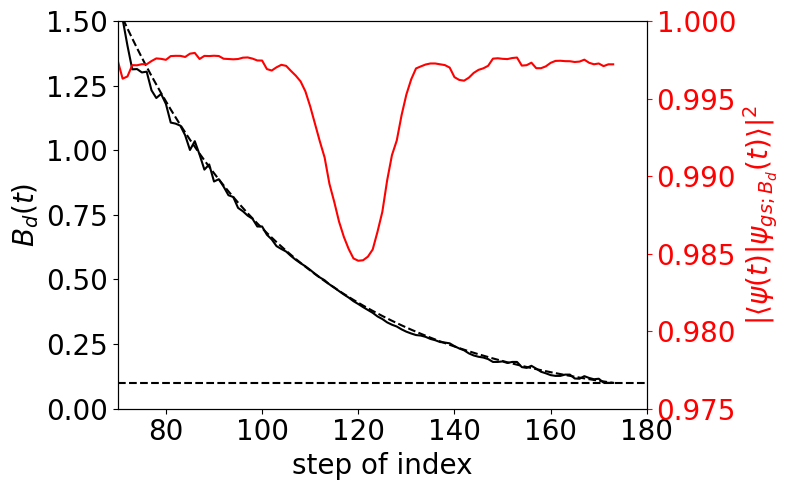

In [83]:
import matplotlib.pyplot as plt

# Create the primary plot with a specified figure size
fig, ax1 = plt.subplots(figsize=(8, 5))  

# Plot B_values and B_guess on the primary y-axis
ax1.plot(B_values, color='black', linestyle='-', label="B Values")  # Solid line
ax1.plot(B_guess, color='black', linestyle='--', label="B Guess")  # Dashed line
ax1.set_xlim(70, 180)
ax1.set_ylim(0, 1.5)
ax1.axhline(y=0.1, color='black', linestyle='--')

# Set primary y-axis labels and ticks to black with larger font size
ax1.set_ylabel(r"$B_d(t)$", color='black', fontsize=20)
ax1.set_xlabel("step of index", fontsize=20)
ax1.tick_params(axis='y', colors='black', labelsize=20)
ax1.tick_params(axis='x', labelsize=20)

# Create the secondary y-axis
ax2 = ax1.twinx()
ax2.plot(fidelity_values, color='red', linestyle='-', label="Fidelity Values")
ax2.set_ylabel(r'$|\langle \psi(t) | \psi_{gs;B_d}(t) \rangle|^2$', color='red', size=20)
ax2.set_ylim(0.975, 1)

# Set secondary y-axis ticks and label to red with larger font size
ax2.tick_params(axis='y', colors='red', labelsize=20)

# Show the plot
plt.tight_layout()
plt.savefig('constant_mte_fidelity.png')
plt.show()

In [66]:
# import seaborn as sns
# import matplotlib.pyplot as plt
# import numpy as np
# from matplotlib.colors import Normalize

# # Parameters
# step_list = np.arange(10, 200, 1)
# lambda_list = np.arange(0.01, 2, 0.01)
# ##### above are the x and y index in the filidety matrix

# # Define fidelity thresholds for easy tuning
# fidelity_threshold_1 = 0.90   # First threshold
# fidelity_threshold_2 = 0.99   # Second threshold
# fidelity_threshold_3 = 0.995  # Third threshold (new)

# # Define specific x-axis tick positions and labels within the range 0.01 to 2
# specific_xticks = np.array([0.01, 1, 2])
# specific_xticklabels = specific_xticks.astype(str)

# # Define the spacing for the y-axis ticks to match your reference style
# y_tick_indices = np.arange(10, 200, 20)  # Adjust to show every 20th step
# y_tick_labels = y_tick_indices.astype(str)

# # Find the indices corresponding to the range 0.01 to 2 in lambda_list
# x_min_idx = np.abs(lambda_list - 0.01).argmin()
# x_max_idx = np.abs(lambda_list - 2).argmin() + 1

# # Slice the fidelity_matrix and lambda_list to limit x-axis to 0.01 to 2
# limited_fidelity_matrix = fidelity_matrix[:, x_min_idx:x_max_idx]
# limited_lambda_list = lambda_list[x_min_idx:x_max_idx]

# # Ensure the number of rows in limited_fidelity_matrix matches step_list
# if limited_fidelity_matrix.shape[0] != len(step_list):
#     raise ValueError("Mismatch between step_list length and fidelity matrix rows.")

# # Set up a custom normalization to highlight values close to 1
# norm = Normalize(vmin=0, vmax=1)

# # Plot heatmap using Seaborn
# plt.figure(figsize=(12, 8))
# ax = sns.heatmap(
#     limited_fidelity_matrix,
#     cmap='viridis',  
#     cbar=True,
#     annot=False,
#     xticklabels=specific_xticklabels,
#     yticklabels=y_tick_labels,
#     cbar_kws={'shrink': 1, 'ticks': np.linspace(0, 1, 11)},  # Color bar range from 0 to 1
#     norm=norm  # Apply custom normalization
# )

# # Adjust x-axis ticks
# ax.set_xticks(np.linspace(0, len(limited_lambda_list) - 1, len(specific_xticks)))
# ax.set_xticklabels(specific_xticklabels, rotation=360)

# # Adjust y-axis ticks to display only the selected indices
# ax.set_yticks(np.linspace(0, len(step_list) - 1, len(y_tick_indices)))
# ax.set_yticklabels(y_tick_labels, rotation=0)

# # Define lists to store step*lambda products for each threshold
# products_1 = []
# products_2 = []
# products_3 = []

# # Find minimum lambda for each fidelity threshold and plot them
# for i, number_of_steps in enumerate(step_list):
#     row_fidelity = limited_fidelity_matrix[i, :]

#     # Find minimum lambda for fidelity > fidelity_threshold_1
#     above_threshold_1_indices = np.where(row_fidelity > fidelity_threshold_1)[0]
#     if len(above_threshold_1_indices) > 0:
#         min_lambda_index_1 = above_threshold_1_indices[0]
#         min_lambda_1 = limited_lambda_list[min_lambda_index_1]
#         products_1.append(number_of_steps * min_lambda_1)
#         plt.plot(min_lambda_index_1, i, marker='o', color='red', markersize=5)  # Red dot

#     # Find minimum lambda for fidelity > fidelity_threshold_2
#     above_threshold_2_indices = np.where(row_fidelity > fidelity_threshold_2)[0]
#     if len(above_threshold_2_indices) > 0:
#         min_lambda_index_2 = above_threshold_2_indices[0]
#         min_lambda_2 = limited_lambda_list[min_lambda_index_2]
#         products_2.append(number_of_steps * min_lambda_2)
#         plt.plot(min_lambda_index_2, i, marker='o', color='black', markersize=5)  # Black dot

#     # Find minimum lambda for fidelity > fidelity_threshold_3
#     above_threshold_3_indices = np.where(row_fidelity > fidelity_threshold_3)[0]
#     if len(above_threshold_3_indices) > 0:
#         min_lambda_index_3 = above_threshold_3_indices[0]
#         min_lambda_3 = limited_lambda_list[min_lambda_index_3]
#         products_3.append(number_of_steps * min_lambda_3)
#         plt.plot(min_lambda_index_3, i, marker='o', color='blue', markersize=5)  # Blue dot

# plt.xlabel(r'$\lambda_0$', size=30)
# plt.ylabel('number of steps', size=30)

# # Set font size of ticks
# plt.xticks(fontsize=20)
# plt.yticks(fontsize=20)

# # Set font size of ticks on color bar
# cbar = ax.collections[0].colorbar
# cbar.ax.tick_params(labelsize=20)

# # Show the plot
# plt.show()


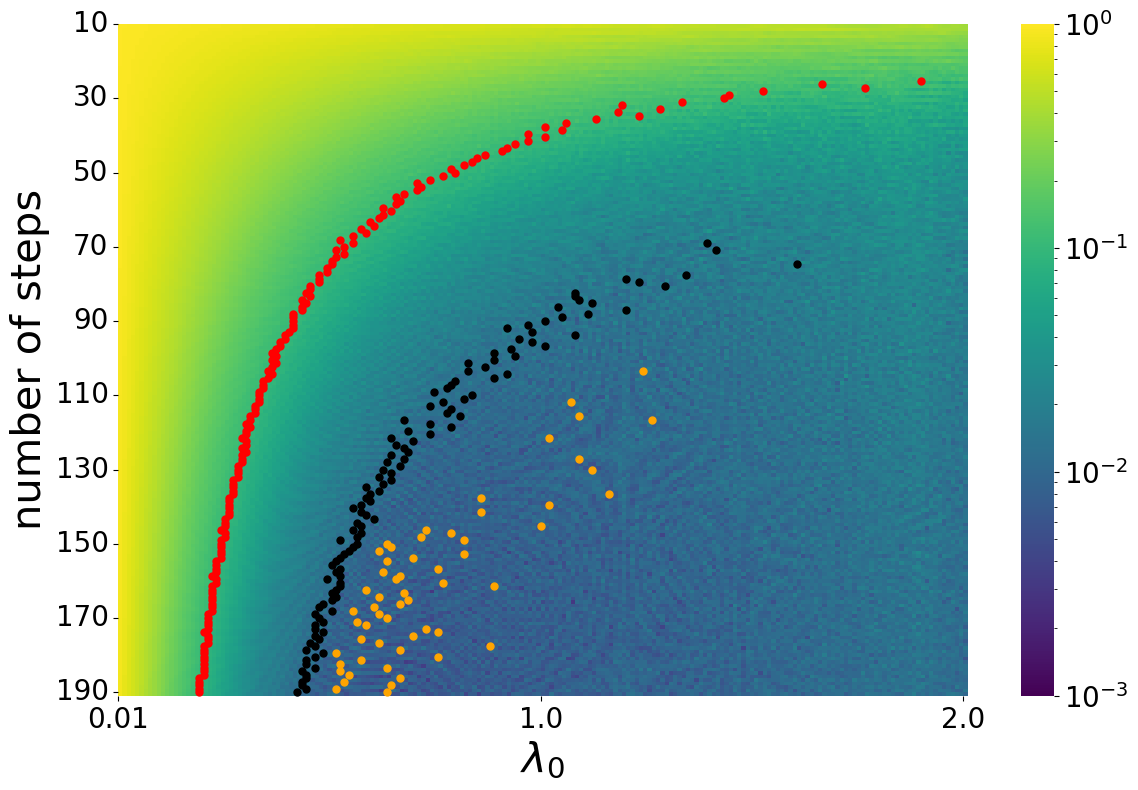

In [68]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import LogNorm

# Parameters
step_list = np.arange(10, 200, 1)
lambda_list = np.arange(0.01, 2, 0.01)

# Define fidelity thresholds (as 1 - fidelity for easier comparison in the transformed matrix)
threshold_1_minus_fidelity_1 = 0.1    # Corresponds to fidelity > 0.9
threshold_1_minus_fidelity_2 = 0.01   # Corresponds to fidelity > 0.99
threshold_1_minus_fidelity_3 = 0.005  # Corresponds to fidelity > 0.995

# Define specific x-axis tick positions and labels within the range 0.01 to 2
specific_xticks = np.array([0.01, 1, 2])
specific_xticklabels = specific_xticks.astype(str)

# Define the spacing for the y-axis ticks to match your reference style
y_tick_indices = np.arange(10, 200, 20)  # Adjust to show every 20th step
y_tick_labels = y_tick_indices.astype(str)

# Find the indices corresponding to the range 0.01 to 2 in lambda_list
x_min_idx = np.abs(lambda_list - 0.01).argmin()
x_max_idx = np.abs(lambda_list - 2).argmin() + 1

# Slice the fidelity_matrix and lambda_list to limit x-axis to 0.01 to 2
limited_fidelity_matrix = fidelity_matrix[:, x_min_idx:x_max_idx]
limited_lambda_list = lambda_list[x_min_idx:x_max_idx]

# Ensure the number of rows in limited_fidelity_matrix matches step_list
if limited_fidelity_matrix.shape[0] != len(step_list):
    raise ValueError("Mismatch between step_list length and fidelity matrix rows.")

# Transform fidelity matrix to 1 - fidelity for plotting
one_minus_fidelity_matrix = 1 - limited_fidelity_matrix

# Set up a logarithmic normalization to highlight small values close to 1
log_norm = LogNorm(vmin=1e-3, vmax=1)  # Adjust vmin as needed to handle small values

# Plot heatmap using Seaborn
plt.figure(figsize=(12, 8))
ax = sns.heatmap(
    one_minus_fidelity_matrix,
    cmap='viridis',  
    cbar=True,
    annot=False,
    xticklabels=specific_xticklabels,
    yticklabels=y_tick_labels,
    cbar_kws={'shrink': 1, 'ticks': [1e-3, 1e-2, 1e-1, 1]},  # Log scale ticks
    norm=log_norm  # Apply logarithmic normalization
)

# Adjust x-axis ticks
ax.set_xticks(np.linspace(0, len(limited_lambda_list) - 1, len(specific_xticks)))
ax.set_xticklabels(specific_xticklabels, rotation=360)

# Adjust y-axis ticks to display only the selected indices
ax.set_yticks(np.linspace(0, len(step_list) - 1, len(y_tick_indices)))
ax.set_yticklabels(y_tick_labels, rotation=0)

# Annotate points where fidelity meets the thresholds
for i, number_of_steps in enumerate(step_list):
    row_one_minus_fidelity = one_minus_fidelity_matrix[i, :]

    # Find minimum lambda for fidelity > 0.9 (1 - fidelity < 0.1)
    threshold_1_indices = np.where(row_one_minus_fidelity < threshold_1_minus_fidelity_1)[0]
    if len(threshold_1_indices) > 0:
        min_lambda_index_1 = threshold_1_indices[0]
        plt.plot(min_lambda_index_1, i, marker='o', color='red', markersize=5)  # Red dot

    # Find minimum lambda for fidelity > 0.99 (1 - fidelity < 0.01)
    threshold_2_indices = np.where(row_one_minus_fidelity < threshold_1_minus_fidelity_2)[0]
    if len(threshold_2_indices) > 0:
        min_lambda_index_2 = threshold_2_indices[0]
        plt.plot(min_lambda_index_2, i, marker='o', color='black', markersize=5)  # Black dot

    # Find minimum lambda for fidelity > 0.995 (1 - fidelity < 0.005)
    threshold_3_indices = np.where(row_one_minus_fidelity < threshold_1_minus_fidelity_3)[0]
    if len(threshold_3_indices) > 0:
        min_lambda_index_3 = threshold_3_indices[0]
        plt.plot(min_lambda_index_3, i, marker='o', color='orange', markersize=5)  # Blue dot

plt.xlabel(r'$\lambda_0$', size=30)
plt.ylabel('number of steps', size=30)

# Set font size of ticks
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

# Set font size of ticks on color bar
cbar = ax.collections[0].colorbar
cbar.ax.tick_params(labelsize=20)

# Show the plot
plt.tight_layout()
plt.savefig('constant_lambda_heatmap.png')
plt.show()
